In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader


In [14]:

data_train = torch.from_numpy(np.load('./x_train.npy'))
label_train = torch.from_numpy(np.load('./y_train.npy'))
data_train = data_train[:,None,:]
data_train = torch.reshape(data_train,(60000,1,28,28))
train = torch.utils.data.TensorDataset(data_train,label_train)

label = np.load('./y_train.npy')
data_test = torch.from_numpy(np.load('./x_test.npy'))
data_test = data_test[:,None,:,:]

In [15]:
print(data_train.shape)
print(data_test.shape)
print(len(train))
print(train[0][1])
print(len(data_train))
print(len(label_train))

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])
60000
tensor(7)
60000
60000


make sure that every piece of data is the expected dimentions

number of 0 images: 5923


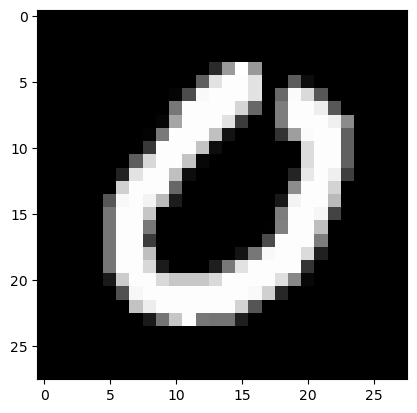

number of 1 images: 6742


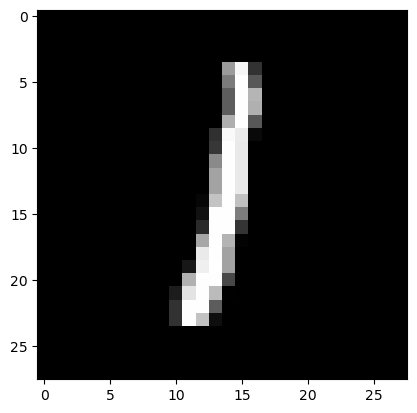

number of 2 images: 5958


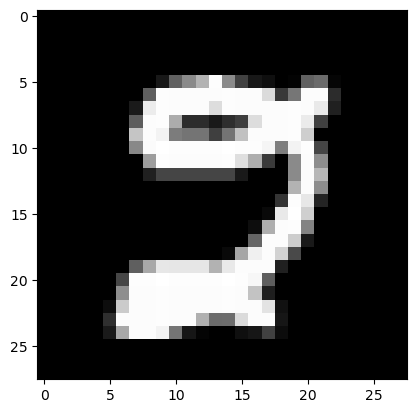

number of 3 images: 6131


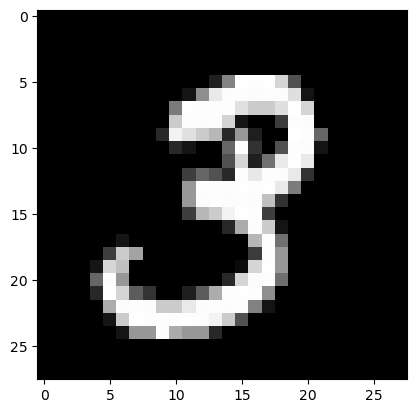

number of 4 images: 5842


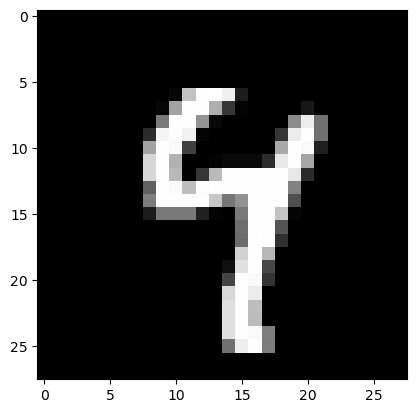

number of 5 images: 5421


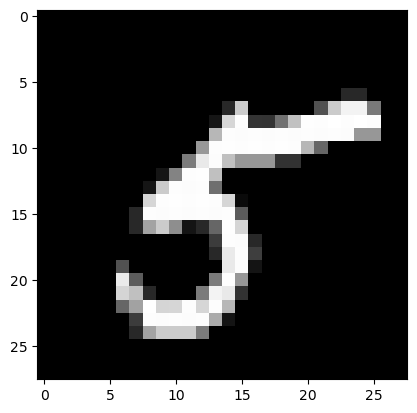

number of 6 images: 5918


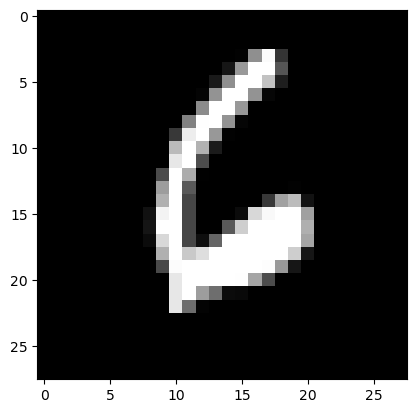

number of 7 images: 6265


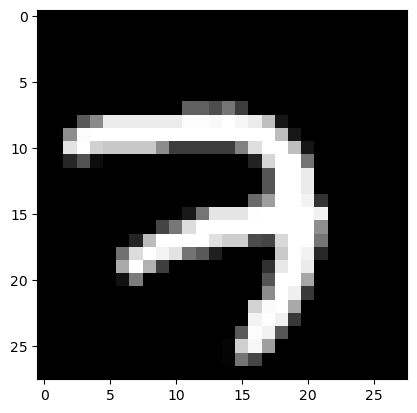

number of 8 images: 5851


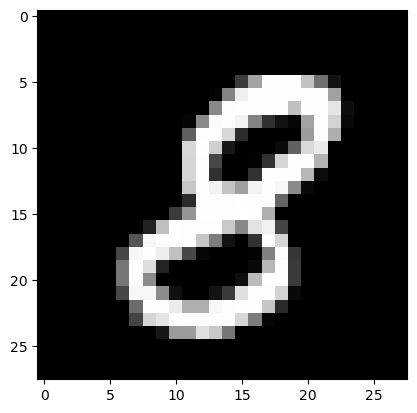

number of 9 images: 5949


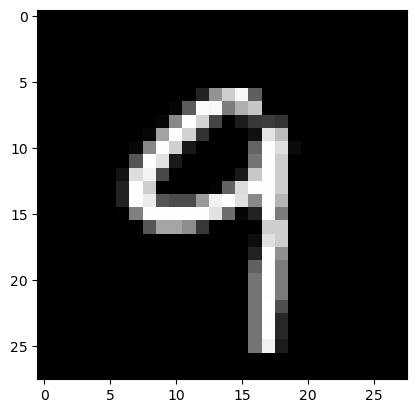

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


In [4]:
ammounts = []
for i in range(10):
    #print(i)
    idx = np.where(label == i)
    ammounts += [len(idx[0])]
    print(f"number of {i} images: {len(idx[0])}")
    #print(data_train[idx[0][0]])
    plt.imshow(data_train[idx[0][0]][0], cmap="gray",interpolation='nearest')
    plt.show()
print(ammounts)

The data distribution is roughly ballanced with each number having around 6000 images except for 1 having ~6800 and 5 having ~5400


In [5]:
train_subset, valid_subset = torch.utils.data.random_split(train,[.8,.2])

train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(data_test, batch_size=64, shuffle=False)

Split the data set up into 2 groups, 1 with 80% of the data and 1 with 20% of the data. Then create dataloaders with each of the different sets of data (train, valid, and test).

In [6]:
from torch import nn

class cnn_block(nn.Module):
  def __init__(self, in_channels = 1, n_hidden = 5, kernel_size = (2, 2), step = 1, padd = 'same'):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(in_channels       = in_channels, out_channels = n_hidden, kernel_size = kernel_size, bias=False, padding = padd, stride=step),
        nn.BatchNorm2d(num_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Conv2d(in_channels       = n_hidden, out_channels = in_channels, kernel_size = kernel_size, bias=False, padding = padd, stride=step),
        nn.BatchNorm2d(num_features = in_channels),
        nn.ReLU(),
        nn.Dropout(p=0.2))

  def forward(self, x):
    return x + self.layers(x)

CNN block with 2d convoluton, normalization, activation, and dropout

In [7]:
class linear_block(nn.Module):
  def __init__(self, in_features, n_hidden):
    super().__init__()
    self.in_features = (in_features, n_hidden)
    self.layers = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = n_hidden),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(in_features = n_hidden, out_features = in_features),
        nn.ReLU()
    )

  def forward(self, x):
    return x + self.layers(x)

Linear Block containing a linear combination of features then an activations function and dropout

In [8]:
class CNNClassifier(nn.Module):
  def __init__(self, in_channels = 3, cnn_channels = 3, linear_hidden = 1000, n_classes = 3, kernel_size = (2, 2), step = 1, padd = 'same'):
    super().__init__()
    self.cnn_layers = nn.Sequential(
        cnn_block(in_channels, cnn_channels, kernel_size, step=step, padd = padd),
        cnn_block(in_channels, cnn_channels, kernel_size, step=step, padd = padd),
        cnn_block(in_channels, cnn_channels, kernel_size, step=step, padd = padd))

    self.down_sample = nn.Conv2d(in_channels = in_channels, out_channels = 1, kernel_size = (1, 1))

    self.linear_layers = nn.Sequential(
        linear_block(28*28, linear_hidden),
        linear_block(28*28, linear_hidden)
    )
    self.last_layer = nn.Linear(28*28, n_classes)

    self.all        = nn.Sequential(
        self.cnn_layers,
        self.down_sample,
        nn.Flatten(),
        self.linear_layers,
        self.last_layer,
    )

  def forward(self, x):
    return self.all(x)

Full CNN Model with CNN and Linear Blocks

cuda


  0%|          | 0/50 [00:00<?, ?it/s]c:\ProgramData\miniconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1041.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 50/50 [14:25<00:00, 17.30s/it]


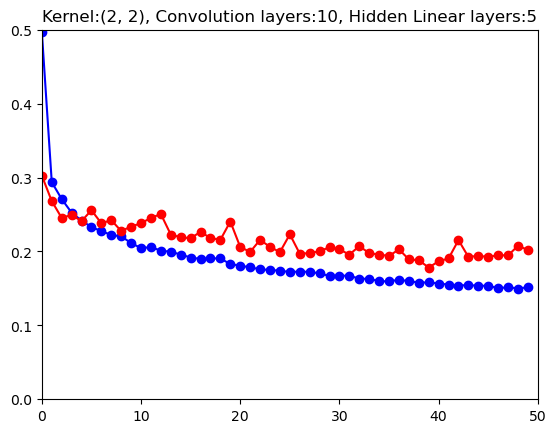

cuda


100%|██████████| 50/50 [13:58<00:00, 16.78s/it]


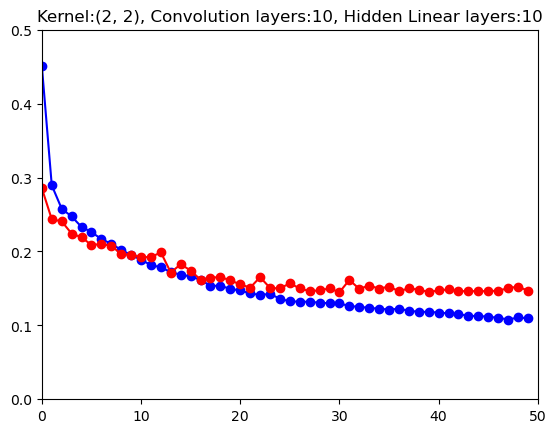

cuda


100%|██████████| 50/50 [14:10<00:00, 17.01s/it]


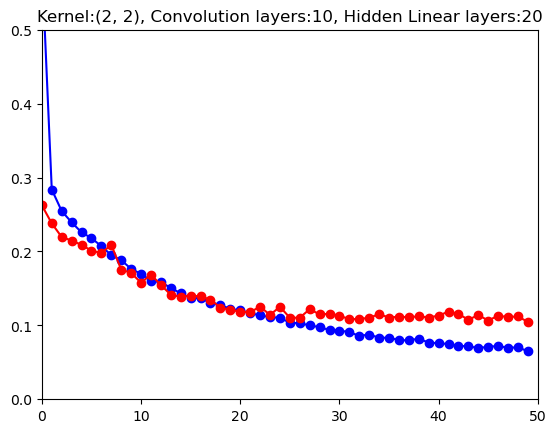

cuda


100%|██████████| 50/50 [24:06<00:00, 28.93s/it]


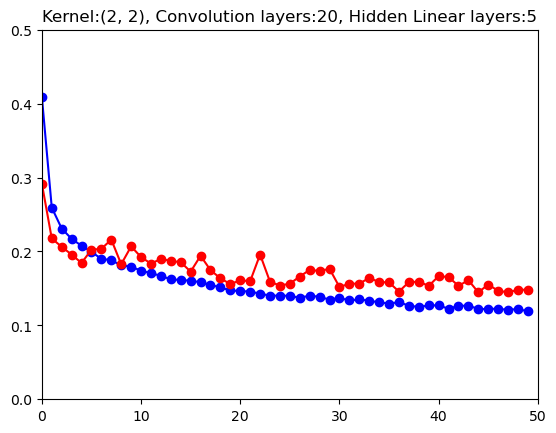

cuda


100%|██████████| 50/50 [23:57<00:00, 28.76s/it]


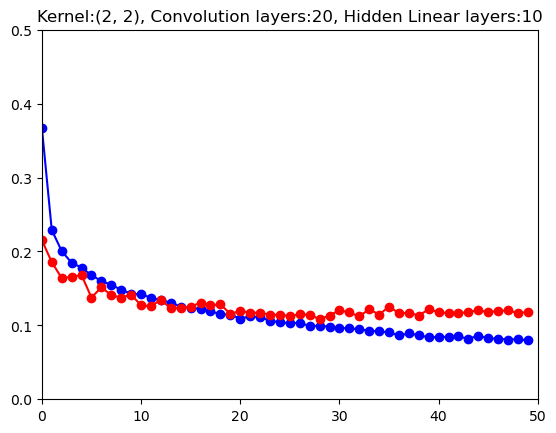

cuda


100%|██████████| 50/50 [24:11<00:00, 29.04s/it]


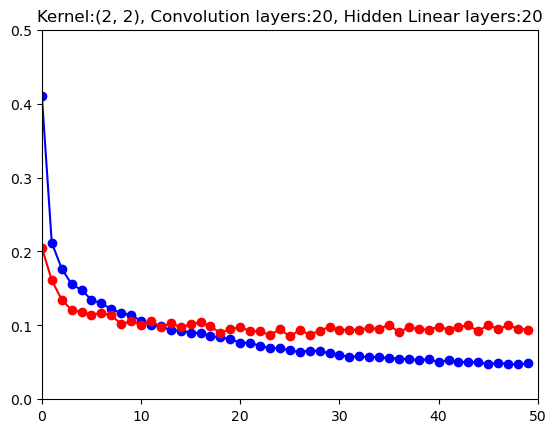

cuda


100%|██████████| 50/50 [39:07<00:00, 46.95s/it]


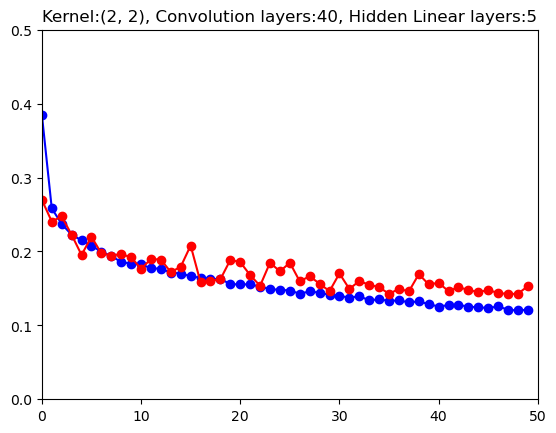

cuda


100%|██████████| 50/50 [39:17<00:00, 47.14s/it]


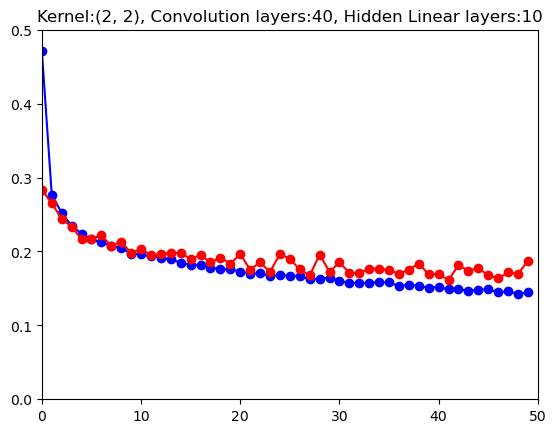

cuda


100%|██████████| 50/50 [39:32<00:00, 47.44s/it]


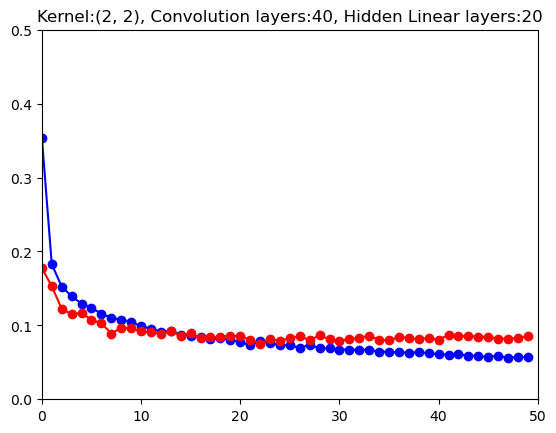

cuda


100%|██████████| 50/50 [21:23<00:00, 25.67s/it]


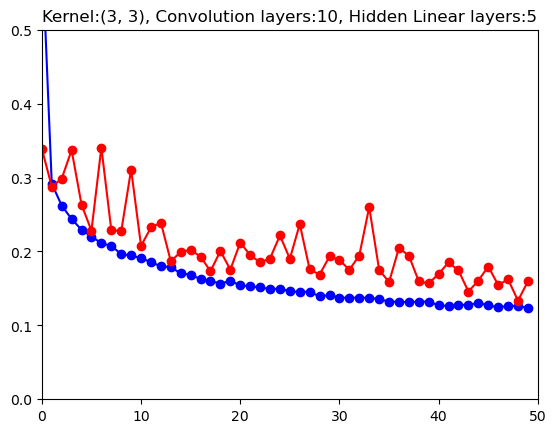

cuda


100%|██████████| 50/50 [21:52<00:00, 26.24s/it]


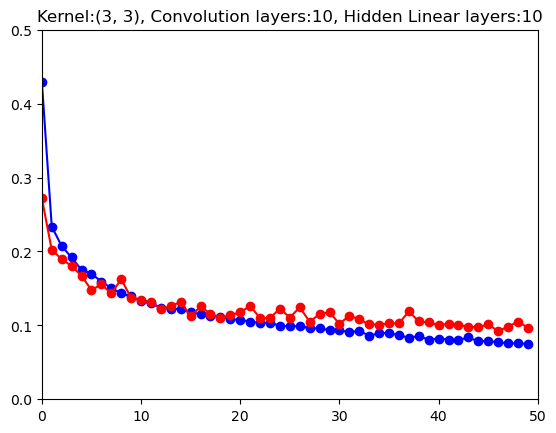

cuda


100%|██████████| 50/50 [21:02<00:00, 25.24s/it]


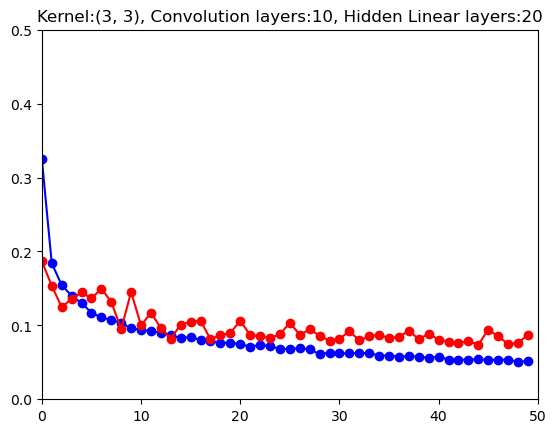

cuda


100%|██████████| 50/50 [34:53<00:00, 41.88s/it]


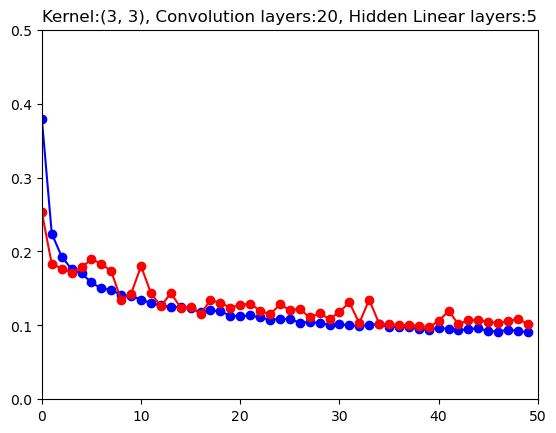

cuda


100%|██████████| 50/50 [35:04<00:00, 42.10s/it]


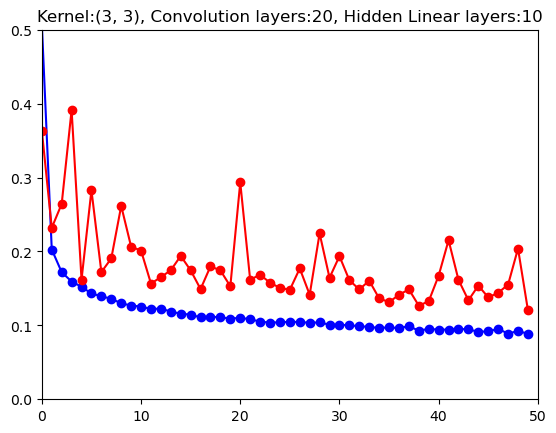

cuda


100%|██████████| 50/50 [35:50<00:00, 43.01s/it]


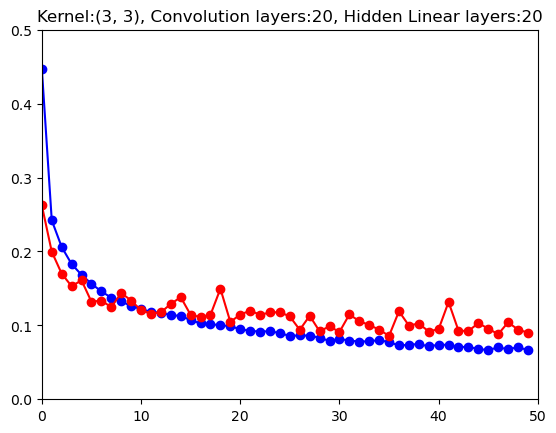

cuda


100%|██████████| 50/50 [1:02:56<00:00, 75.53s/it]


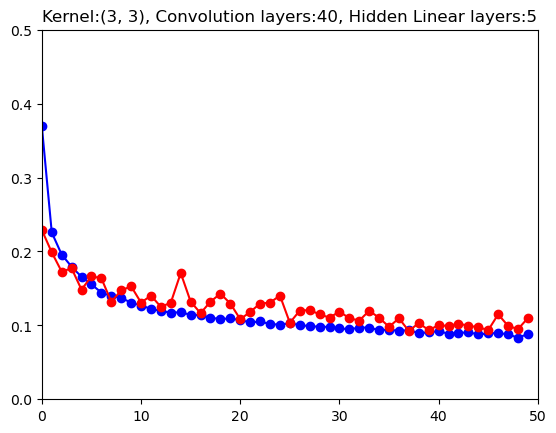

cuda


100%|██████████| 50/50 [1:06:23<00:00, 79.67s/it]


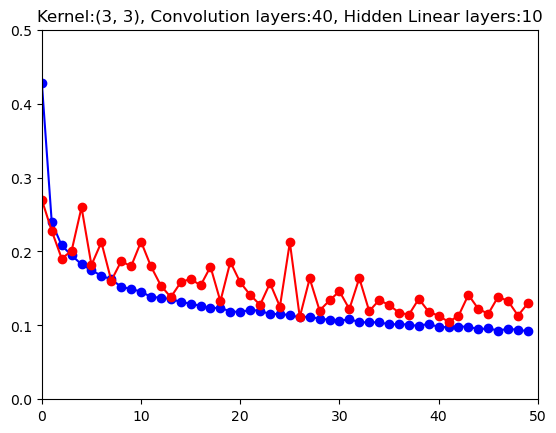

cuda


100%|██████████| 50/50 [1:03:29<00:00, 76.19s/it]


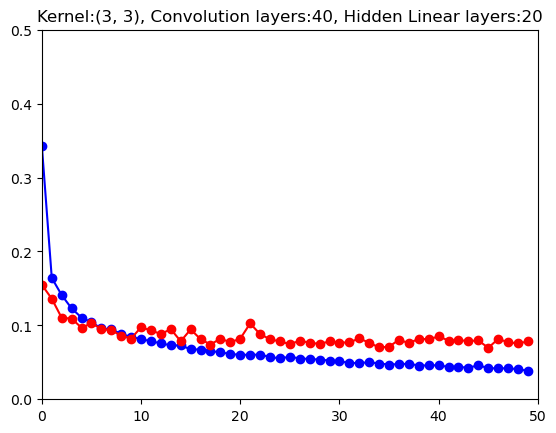

cuda


100%|██████████| 50/50 [24:25<00:00, 29.31s/it]


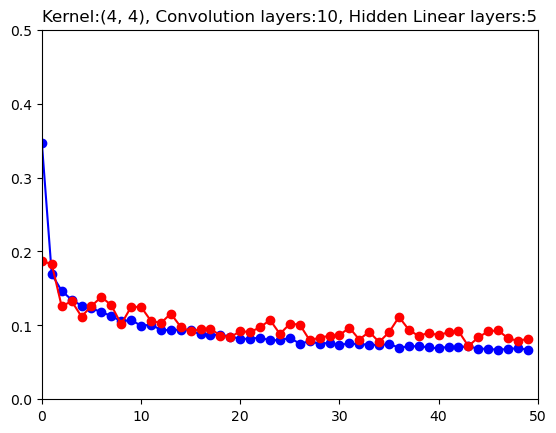

cuda


100%|██████████| 50/50 [25:15<00:00, 30.32s/it]


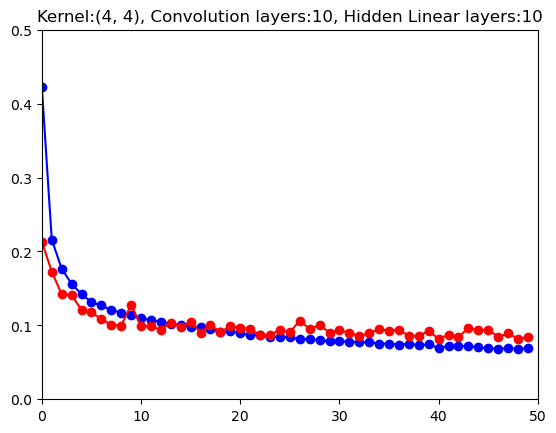

cuda


  0%|          | 0/50 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [9]:
import numpy as np
from tqdm import tqdm
from torch.optim import Adam

n_epochs = 50
train_loss, test_loss = [], []
kernel_sizes = [(2,2), (3,3), (4,4), (5,5)]
Linear_layers = [5, 10, 20]
Con_layers = [10,20,40]

test_evals = []
train_evals = []

for kernel in kernel_sizes:
    for num_con_layer in Con_layers:
        for num_lin_layer in Linear_layers:
            device    = 'cuda' if torch.cuda.is_available() else 'cpu'
            model     = CNNClassifier(in_channels = 1,
                                      cnn_channels = num_con_layer,
                                      linear_hidden = num_lin_layer,
                                      n_classes = 10,
                                      kernel_size = kernel,
                                      ).to(device)
            model.double()
            loss_fn   = nn.CrossEntropyLoss()
            optimizer = Adam(model.parameters(), lr = 1e-3)
            print(device)
            train_loss = []
            test_loss = []
            for epoch in tqdm(range(n_epochs)):

                # do a loop over all training samples
                model.train() # telling the model we are training it as it needs to keep track of gradients (and other things) in this modality
                epoch_train_loss = []
                for batch, (X, y) in enumerate(train_dataloader):
                    X, y = X.to(device), y.to(device)

                    preds = model(X)

                    loss = loss_fn(preds, y)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_train_loss.append(loss.item())

                # do a loop over all testing samples
                model.eval() # telling the model we are evaluating it
                epoch_test_loss = []
                with torch.no_grad(): # alternatively, torch.no_grad()
                    for batch, (X, y) in enumerate(valid_dataloader):
                        X, y = X.to(device), y.to(device)
                        preds = model(X)
                        loss  = loss_fn(preds, y)
                        epoch_test_loss.append(loss.item())

                train_loss.append(np.mean(epoch_train_loss))
                test_loss.append(np.mean(epoch_test_loss))

            test_evals += [test_loss[-1]]
            train_evals += [train_loss[-1]]
            plt.title(f"Kernel:{kernel}, Convolution layers:{num_con_layer}, Hidden Linear layers:{num_lin_layer}")
            plt.plot(np.arange(epoch+1),train_loss,'-bo')
            plt.plot(np.arange(epoch+1),test_loss,'-ro')
            plt.xlim([0, n_epochs])
            plt.ylim([0, .5])
            plt.show()

print(f"test losses:{test_evals}")
print(f"train losses:{train_evals}")


Terminated Early because results werent getting better as parameters changed to higher kernels

For every permutation of the hyper parameters train the model on the data and then plot the training loss vs the validation loss to determine which set of hyperparameters works best

In [ ]:
print(test_loss)
print(train_loss)

[0.2897733372538226, 0.2193045553557987, 0.19254487048740468, 0.18514323440592836, 0.18175153270148264, 0.19819413838369265, 0.16256761996482227, 0.1796998493917342, 0.18509426048728364, 0.13554976130618845, 0.15273055628641963, 0.15992584160570092, 0.1610778397413114, 0.14544006220612385, 0.15601685195023296, 0.1482639959249718, 0.13594648853260852, 0.14997402409131116, 0.1497747963908752, 0.12939725861948748, 0.15336211636754904, 0.14266782295235936, 0.14067399656509016, 0.18039788468031245, 0.12284928355128479, 0.15677775765279334, 0.14082434042384456, 0.13860847897614822, 0.14675349522567, 0.127879213010997, 0.12231427859913718, 0.12516651507924922, 0.10545067341730291, 0.12034188953932964, 0.12287174875149019, 0.12446310520540851, 0.14176668338480303, 0.12805467861786068, 0.11640747942052365, 0.12376149201071081, 0.12205654274482071, 0.1206451066157568, 0.12202003371208109, 0.13082718565943863, 0.14023252868284208, 0.11839672078539741, 0.1323270585572781, 0.12616632325377725, 0.16

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_model  = CNNClassifier(in_channels = 1,
                            cnn_channels = 10,
                            linear_hidden = 20,
                            n_classes = 10,
                            kernel_size = (3,3),
                            ).to(device)
best_model.double()
loss_fn   = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 1e-3)
print(device)
train_loss = []
test_loss = []
for epoch in tqdm(range(n_epochs)):

    # do a loop over all training samples
    best_model.train() # telling the model we are training it as it needs to keep track of gradients (and other things) in this modality
    epoch_train_loss = []
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        preds = best_model(X)

        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss.append(loss.item())

    # do a loop over all testing samples
    best_model.eval() # telling the model we are evaluating it
    epoch_test_loss = []
    with torch.no_grad(): # alternatively, torch.no_grad()
        for batch, (X, y) in enumerate(valid_dataloader):
            X, y = X.to(device), y.to(device)
            preds = best_model(X)
            loss  = loss_fn(preds, y)
            epoch_test_loss.append(loss.item())

    train_loss.append(np.mean(epoch_train_loss))
    test_loss.append(np.mean(epoch_test_loss))

print(f"Final Train loss: {train_loss[-1]}")
print(f"Final Test loss: {test_loss[-1]}")

cuda


100%|██████████| 50/50 [21:36<00:00, 25.93s/it]

Final Train loss: 2.6010681062995866
Final Test loss: 2.4528131936273323


Retrain the best model and record the final train and test loss for the model

In [22]:
data = data_test.to(device)
preds = best_model(data)
with open("preds.csv",'w+') as file:
    file.write(f"preds\n")
    for pred in preds:
        file.write(f"{pred.tolist().index(max(pred))}\n")

Since the model returns a percentage, take the index of the max value to determine what number is being predicted and write it to a csv file